# Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `figure9_sdv_treatment_defined_by_deltadce.ipynb` from `figureX_sdv.ipynb`
### This script simply recalculates all the sdv work to say "change" is defined by deltaDCE, everything else is the same as `figureX_sdv.ipynb`

created by Cassie Lumbrazo\
last updated: July 2025\
run location: UAS Linux\
python environment: **cer_treatment**

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
# ds = xr.open_dataset('~/RAPID/cer_treatment_region_dataset_all_variables/cer_treatment_region_dataset_all_variables.nc') # Steven's path
# ds = xr.open_dataset('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_treatment_manuscript\\cer_treatment_region_dataset_all_variables.nc') # Cassie local path
figure_path = '/home/cassie/data/cer_treatment_manuscript/figures/' # Cassie remote path on new linux machine

ds = xr.open_dataset('/home/cassie/data/cer_treatment_manuscript/cer_treatment_region_dataset_all_variables.nc') # Cassie remote path on new linux machine

---

In [3]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 21kB 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 11kB 2.111e+05 ... 2.097e+05
  * band                              (band) int32 4B 1
    spatial_ref                       int32 4B ...
Data variables: (12/337)
    chmws_rapid                       (band, y, x) float32 14MB ...
    dce_rapid                         (band, y, x) float32 14MB ...
    giulia_dce_rapid                  (band, y, x) float32 14MB ...
    giulia_dce_ncalm                  (band, y, x) float32 14MB ...
    slope                             (band, y, x) float32 14MB ...
    aspect                            (band, y, x) float32 14MB ...
    ...                                ...
    hs_rapid_baf_new_100s_n           (band, y, x) float32 14MB ...
    hs_rapid_baf_new_30s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_60s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_80s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_90s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_100s_s           (band, y, x) float32 14MB ...

In [4]:
color_cat1='olivedrab' # forest growth (forest to denser forest)
color_cat2='cornflowerblue' # forest thinning (forest to forest edge)
color_cat3='black' # no change (delta DCE close to zero)
color_cat4='mediumseagreen' # forest growth (open to less open)
color_cat5='saddlebrown' # forest thinning (open to more open)
color_cat6='darkslateblue' # forest thinning (forest to open)

In [5]:
# Constants 
# colors
colorpre='darkslategray'
colorpos='royalblue'
# colorpos='mediumvioletred'

colorsouth = 'darkorange'
colornorth = 'darkblue'

# colorcontrol = 'dimgray'
colorcontrol = 'saddlebrown'
colortreatment = 'darkcyan'
colortreatment2 = 'darkslategrey'

### Compute Standardized Depth Values (SDV)

We want to compare maps of snow depth on two different years, but rather than compare their depths directly, we will use a standardized depth value (SDV). SDV relates how snow depth in a single pixel or point relates to the mean and standard deviation of snow depths throughout the study area. In this way we can see how a single pixel relates to the snow depths in the study area in year 1, then again in year 2, and see if there was a significant change.

Because we anticipate snow depths changing due to changes in forest structure, we should use the mean and standard deviation of the "control" areas where no human-made forest structure change occurred. Additionally, areas with a snow depth of 0 do not provide us with any information (we don't know how snow in that pixel related to the snow depths across the rest of the study area) and therefore should be removed. Areas with a snow depth of 0 in either year should be removed from *both* years so that we can directly compare changes in pairs of pixels with information in both years.

We can then look at histogram or CDF plots to see how distribution of SDV changed between the two years.

---

### Add Code from `11_delta_dce_categories.ipynb` to normalize snow depth the same way as we do for the delta dce

In [6]:
# Calculate delta DCE
delta_dce = ds['dce_rapid'] - ds['dce_ncalm']

# Create a new variable to store the categories
# Category 1: Forest Growth: forest to denser forest (ncalm negative, rapid negative, delta DCE negative)
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce < 0), 1, 0)

# Category 2: Forest Thinning: forest to forest edge (ncalm negative, rapid negative, delta DCE positive) 
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce > 0), 2, ds['delta_dce_cat'])

# Category 3: No Change (delta DCE close to zero (absolute value less than 0.5))
ds['delta_dce_cat'] = xr.where(np.abs(delta_dce) < 0.5, 3, ds['delta_dce_cat'])

# Category 4: Forest Growth: open to less open (ncalm positive, rapid less than ncalm) 
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] < ds['dce_ncalm']), 4, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce < 0), 4, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 5: Forest Thinning: open to more open (ncalm positive, rapid greater than ncalm)
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] > ds['dce_ncalm']), 5, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce > 0), 5, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 6: Forest Thinning: forest to open (ncalm negative, rapid positive)
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] > 0), 6, ds['delta_dce_cat'])

#### DeltaDCE Catgeories, 
* Category 1: Forest Growth (forest to denser forest) --> non-treatment area  
* Catgeory 2: Forest Thinning (forest to forest edge) --> treatment area 
* Catgeory 3: No Change --> non-treatment area
* Catgeory 4: Forest Growth (open to less open) --> non-treatment area 
* Catgeory 5: Forest Thinning (open to more open) --> treatment area 
* Catgeory 6: Forest Thinning (forest to open) --> treatment area 

## Redefine Treatment Areas 
So the catgeories which define forest thinning are the "treatment" areas now, and the categories which define forest growth or no change are the "control" or "non-treatment" areas, 
* `Treatment Area: Category 2, 5, 6`
* `Non-Treatment Area: Catgeory 1, 3, 4`

In [7]:
# Calculate mean and standard deviation of snow depth for delta DCE category 3 (no change)
mean_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).mean()
std_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).std()

mean_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).mean()
std_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).std()

# Normalize snow depth for each year
ds['hs_ncalm_normalized'] = (ds['hs_ncalm'] - mean_2021) / std_2021
ds['hs_rapid_normalized'] = (ds['hs_rapid'] - mean_2023) / std_2023

# Calculate the difference in normalized snow depth 
ds['hs_diff_normalized'] = ds['hs_rapid_normalized'] - ds['hs_ncalm_normalized']

# Print the means and stds 
print('ΔDCE Category 3 Mean 2021:', mean_2021.values.round(3))
print('ΔDCE Category 3 Mean 2023:', mean_2023.values.round(3))
print('ΔDCE Category 3 Std 2021:', std_2021.values.round(3))
print('ΔDCE Category 3 Std 2023:', std_2023.values.round(3))

ΔDCE Category 3 Mean 2021: 0.167
ΔDCE Category 3 Mean 2023: 0.198
ΔDCE Category 3 Std 2021: 0.225
ΔDCE Category 3 Std 2023: 0.235


Before computing SDV, we should remove all locations that had a depth value of 0 in either year 1 or year 2. When we have a depth of 0, we don't actually know how this location compares (in terms of SDV, or number of standard deviations from the mean) with the rest of the study area.

In [8]:
ds['hs_ncalm_zeros_removed'] = ds['hs_ncalm'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))
ds['hs_rapid_zeros_removed'] = ds['hs_rapid'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))

### Compute SDV

SDV = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey

We only want to base the SDV mean and standard deviation on the "control areas" where there was no prescribed forest structure change the BAF data variable is NaN for the "control" areas (np.isnan(ds.baf)), and has a value in the "treatment" areas (~np.isnan(ds.baf)).

In [9]:
ds['sdv_rapid'] = (ds['hs_rapid_zeros_removed'] - ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])
ds['sdv_ncalm'] = (ds['hs_ncalm_zeros_removed'] - ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm'] = (ds['sdv_rapid'] - ds['sdv_ncalm']) # 2023 SDV - 2021 SDV

Now, do the same calculation for the new normalized methods (same as the deltaDCE)

In [10]:
# Now, redo that code but with the new normalized snow depth values from delta DCE 
ds['sdv_rapid_new_norm'] = (ds['hs_rapid_zeros_removed'] - mean_2023) / std_2023 # those mean and std are calculated above with detla DCE
ds['sdv_ncalm_new_norm'] = (ds['hs_ncalm_zeros_removed'] - mean_2021) / std_2021 # those mean and std are calculated above with delta DCE

ds['diff_sdv_rapid_ncalm_new_norm'] = (ds['sdv_rapid_new_norm'] - ds['sdv_ncalm_new_norm']) # 2023 SDV - 2021 SDV

In [11]:
# print the median values with the new normalized sdv diff
print(f'median south new norm: ', ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  1).median().values)
print(f'median north new norm: ', ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] == -1).median().values)

median south new norm:  0.37010223
median north new norm:  0.2226932


## This is where we define **treatment** and **non-treatment** (*control*) areas 
#### so let's change this from defined by the `baf` polygons, to being defined by the `deltaDCE` nochange area
* `Treatment Area: Category 2, 5, 6`
* `Non-Treatment Area: Catgeory 1, 3, 4`

Now, just look at treatment and control across the ridge, 

In [12]:
ds['sdv_diff_treatment_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)) # previously defined as treatment where the baf is not nan
ds['sdv_diff_control_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf))

# now we define treatment as where the deltaDCE category 3 is nan 
# ds['sdv_diff_treatment_new_norm_cat'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['delta_dce_cat'] == 2 & ds['delta_dce_cat'] == 5 & ds['delta_dce_cat'] == 6) # now, define treatment as anywhere where deltadce changed
# ds['sdv_diff_control_new_norm_cat']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['delta_dce_cat'] == 1 & ds['delta_dce_cat'] == 3 & ds['delta_dce_cat'] == 4)

# Define treatment as where delta_dce_cat is in [2, 5, 6]
ds['sdv_diff_treatment_new_norm_cat'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(
    ds['delta_dce_cat'].isin([2, 5, 6])
)

# Define control as where delta_dce_cat is in [1, 3, 4]
ds['sdv_diff_control_new_norm_cat'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(
    ds['delta_dce_cat'].isin([1, 3, 4])
)

In [13]:
# print the medians from the plot with the new normalized sdv diff
print(f'median treatment new norm: ', ds['sdv_diff_treatment_new_norm'].median().values)
print(f'median control new norm: ', ds['sdv_diff_control_new_norm'].median().values)

print(f'median treatment new norm cat: ', ds['sdv_diff_treatment_new_norm_cat'].median().values)
print(f'median control new norm cat: ', ds['sdv_diff_control_new_norm_cat'].median().values)

median treatment new norm:  0.35993037
median control new norm:  0.1828331
median treatment new norm cat:  0.530897
median control new norm cat:  0.09656481


Now, north and south by treated and untreated areas

In [14]:
# for the treatment and control, north and south with the new normalized sdv diff
ds['sdv_diff_treatment_south_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
ds['sdv_diff_control_south_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_control_north_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)

# for the treatment and control, north and south with the new normalized sdv diff
ds['sdv_diff_treatment_south_new_norm_cat'] = ds['sdv_diff_treatment_new_norm_cat'].where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north_new_norm_cat'] = ds['sdv_diff_treatment_new_norm_cat'].where(ds.baf_ridge == -1)
ds['sdv_diff_control_south_new_norm_cat']   = ds['sdv_diff_control_new_norm_cat'].where(ds.baf_ridge == 1)
ds['sdv_diff_control_north_new_norm_cat']   = ds['sdv_diff_control_new_norm_cat'].where(ds.baf_ridge == -1)

Print the medians, 

In [15]:
# print the medians, for the new normalized sdv diff
print(f'median control south new norm: ', ds['sdv_diff_control_south_new_norm'].median().values)
print(f'median treatment south new norm: ', ds['sdv_diff_treatment_south_new_norm'].median().values)
print(f'median control north new norm: ', ds['sdv_diff_control_north_new_norm'].median().values)
print(f'median treatment north new norm: ', ds['sdv_diff_treatment_north_new_norm'].median().values)

# print the medians, for the new normalized sdv diff
print(f'median control south new norm cat: ', ds['sdv_diff_control_south_new_norm_cat'].median().values)
print(f'median treatment south new norm cat: ', ds['sdv_diff_treatment_south_new_norm_cat'].median().values)
print(f'median control north new norm cat: ', ds['sdv_diff_control_north_new_norm_cat'].median().values)
print(f'median treatment north new norm cat: ', ds['sdv_diff_treatment_north_new_norm_cat'].median().values)

median control south new norm:  0.38717398
median treatment south new norm:  0.3648748
median control north new norm:  -0.19350524
median treatment north new norm:  0.35081443
median control south new norm cat:  0.31065053
median treatment south new norm cat:  0.44815266
median control north new norm cat:  -0.39755794
median treatment north new norm cat:  0.6210938


# Figure 9 SVD

### First, left side of Figure 9

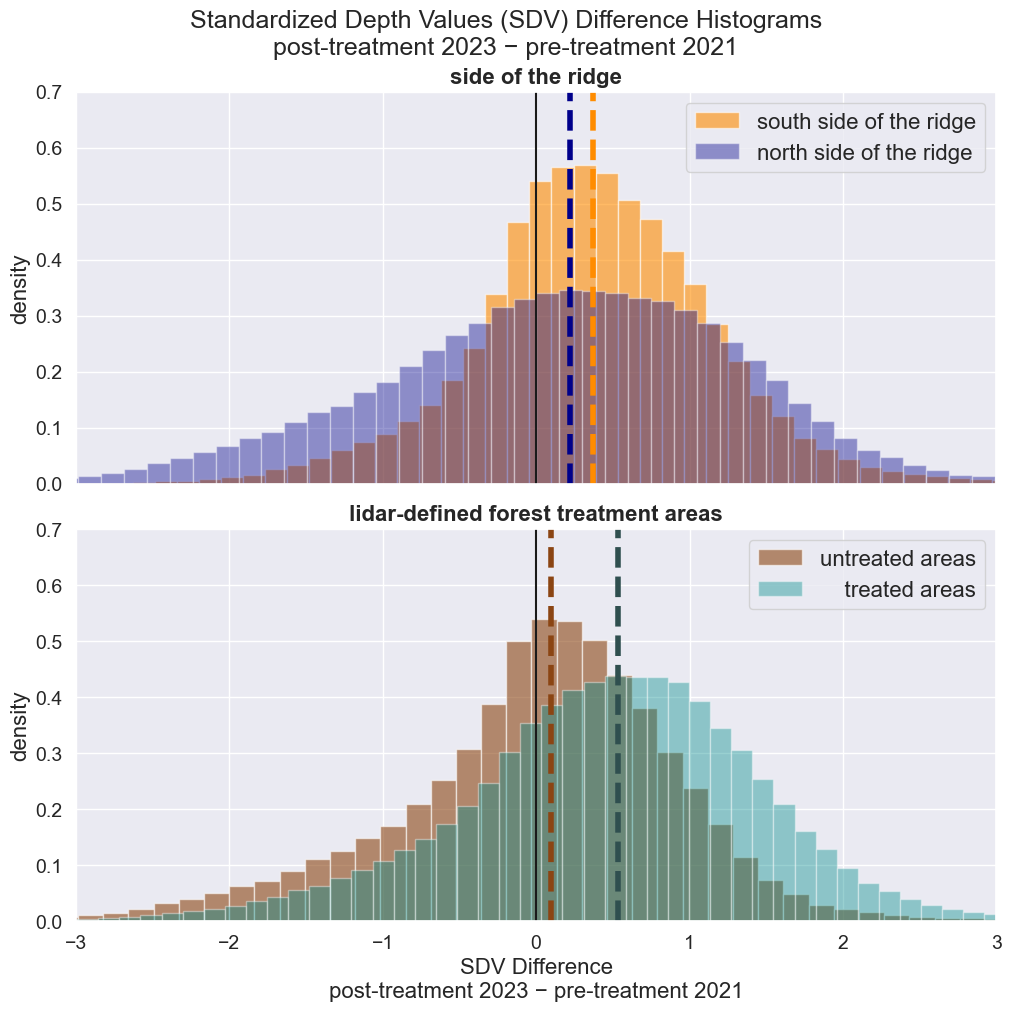

In [16]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,10), constrained_layout = True)

ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  1).plot.hist(ax=axes[0], bins=100, color=colorsouth, alpha=0.6, density=True, label='south side of the ridge');
ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] == -1).plot.hist(ax=axes[0], bins=100, color=colornorth, alpha=0.4, density=True, label='north side of the ridge');
ds['sdv_diff_control_new_norm_cat'].plot.hist(  ax=axes[1], bins=100, color=colorcontrol, alpha=0.6, density=True, label='untreated areas');
ds['sdv_diff_treatment_new_norm_cat'].plot.hist(ax=axes[1], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');

# plot the median line 
axes[0].axvline(ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  1).median(), color=colorsouth, linestyle='dashed', linewidth=4, label='');
axes[0].axvline(ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] == -1).median(), color=colornorth, linestyle='dashed', linewidth=4, label='');
axes[1].axvline(ds['sdv_diff_control_new_norm_cat'].median(), color=colorcontrol, linestyle='dashed', linewidth=4, label='');
axes[1].axvline(ds['sdv_diff_treatment_new_norm_cat'].median(), color=colortreatment2, linestyle='dashed', linewidth=4, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
# axes[0].legend(loc=(1.02,.5));
axes[0].legend(fontsize = 16)
axes[1].legend(fontsize = 16)

axes[0].set_ylim(0,0.7);
axes[0].set_xlim(-3,3);
axes[0].set_ylabel('density', fontsize = 16)
axes[1].set_ylabel('density', fontsize = 16)

axes[0].set_xlabel('')
axes[1].set_xlabel('SDV Difference\npost-treatment 2023 − pre-treatment 2021', fontsize=16)

plt.suptitle('Standardized Depth Values (SDV) Difference Histograms\npost-treatment 2023 − pre-treatment 2021', fontsize=18)
# plt.suptitle('Standardized Depth Values (SDV) Difference Histograms', fontsize=18)

axes[0].set_title('side of the ridge', fontsize = 16, fontweight = 'bold')
axes[1].set_title('lidar-defined forest treatment areas', fontsize = 16, fontweight = 'bold')

# increase the size of the x and y ticks 
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=14)

# export the figure with high resolution
figure_name = 'figure9_final_left.png'
plt.savefig(figure_path + figure_name, dpi=600, bbox_inches='tight')

plt.show()

### Right side of Figure 9, 

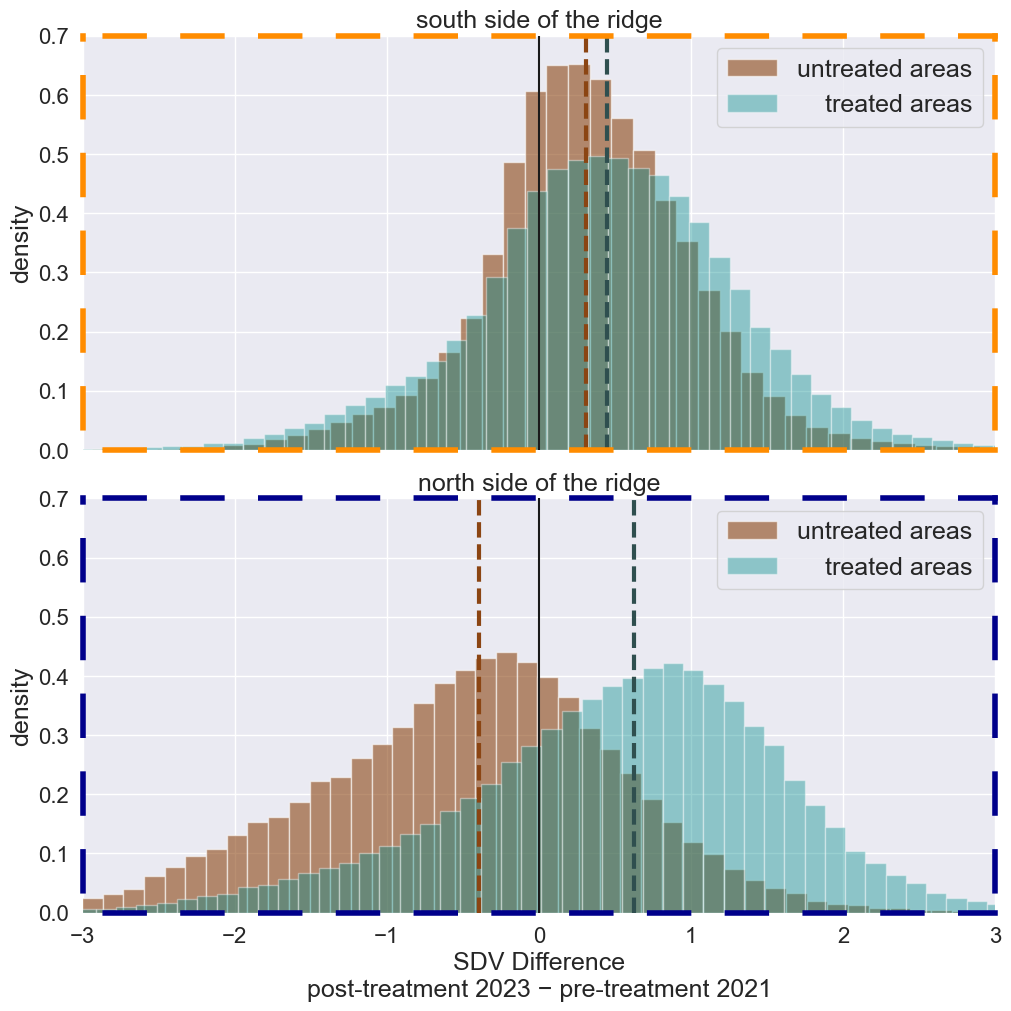

In [17]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,10), constrained_layout = True)
ds['sdv_diff_control_south_new_norm_cat'].plot.hist(ax=axes[0], bins=100, color=colorcontrol, alpha=0.6, density=True, label='untreated areas');
ds['sdv_diff_treatment_south_new_norm_cat'].plot.hist(ax=axes[0], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');
ds['sdv_diff_control_north_new_norm_cat'].plot.hist(ax=axes[1], bins=100, color=colorcontrol, alpha=0.6, density=True, label='untreated areas');
ds['sdv_diff_treatment_north_new_norm_cat'].plot.hist(ax=axes[1], bins=100, color=colortreatment, alpha=0.4, density=True, label='    treated areas');

# plot the median line 
axes[0].axvline(ds['sdv_diff_control_south_new_norm_cat'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[0].axvline(ds['sdv_diff_treatment_south_new_norm_cat'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_control_north_new_norm_cat'].median(), color=colorcontrol, linestyle='dashed', linewidth=3, label='');
axes[1].axvline(ds['sdv_diff_treatment_north_new_norm_cat'].median(), color=colortreatment2, linestyle='dashed', linewidth=3, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
# axes[0].legend(loc=(1.02,.5));
axes[0].legend(fontsize = 18)
axes[1].legend(fontsize = 18)

axes[0].set_ylim(0,0.7);
axes[0].set_xlim(-3,3);
axes[0].set_ylabel('density', fontsize = 18)
axes[1].set_ylabel('density', fontsize = 18)

axes[0].set_xlabel('')
axes[1].set_xlabel('SDV Difference\npost-treatment 2023 − pre-treatment 2021', fontsize=18)


# plt.suptitle('Standardized Depth Values (SDV) Difference Histogram')

axes[0].set_title('south side of the ridge', fontsize = 18)
axes[1].set_title('north side of the ridge', fontsize = 18)

# increase the size of the x and y ticks 
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=16)

# make an orange outline on the first subplot 
for spine in axes[0].spines.values():
    spine.set_edgecolor(colorsouth)
    spine.set_linewidth(4)
    # spine.set_linestyle('dashed')
    spine.set_linestyle((10, (7,7))) # line width, then (points, gap)
    
# make a blue outline on the second subplot
for spine in axes[1].spines.values():
    spine.set_edgecolor(colornorth)
    spine.set_linewidth(4)
    spine.set_linestyle((10, (7,7)))
    
# # add a C) and D) to the subplots 
# axes[0].text(0.01, 0.9, 'C)', fontsize=18, transform=axes[0].transAxes)
# axes[1].text(0.01, 0.9, 'D)', fontsize=18, transform=axes[1].transAxes)

# export the figure with high resolution
# figure_name = 'figure9_sdv_right.jpg'
figure_name = 'figure9_final_right.png'
plt.savefig(figure_path + figure_name, dpi=600, bbox_inches='tight')

plt.show()

### Print The Values (median) for the Manuscript

In [18]:
# print the mean and standard deviation for all the groups plotted above
print("All values are for the new normalized SDV difference with delta DCE categories")
print(f'mean south: ', ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  1).mean().round(2).values)
print(f'mean north: ', ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] == -1).mean().round(2).values)
print(f'mean control: ', ds['sdv_diff_control_new_norm_cat'].mean().round(2).values)
print(f'mean treatment: ', ds['sdv_diff_treatment_new_norm_cat'].mean().round(2).values)

print(f'median south: ', ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  1).median().round(2).values, "(reported in the text)")
print(f'median north: ', ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] == -1).median().round(2).values, "(reported in the text)")
print(f'median control: ', ds['sdv_diff_control_new_norm_cat'].median().round(2).values, "(reported in the text)")
print(f'median treatment: ', ds['sdv_diff_treatment_new_norm_cat'].median().round(2).values, "(reported in the text)")

print(f'std south: ', ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] ==  1).std().round(2).values)
print(f'std north: ', ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['baf_ridge'] == -1).std().round(2).values)
print(f'std control: ', ds['sdv_diff_control_new_norm_cat'].std().round(2).values)
print(f'std treatment: ', ds['sdv_diff_treatment_new_norm_cat'].std().round(2).values)

All values are for the new normalized SDV difference with delta DCE categories
mean south:  0.38
mean north:  0.16
mean control:  0.02
mean treatment:  0.48
median south:  0.37 (reported in the text)
median north:  0.22 (reported in the text)
median control:  0.1 (reported in the text)
median treatment:  0.53 (reported in the text)
std south:  0.82
std north:  1.16
std control:  0.96
std treatment:  0.99


In [19]:
# print the mean and standard deviation for the south and north side of the ridge
print(f'mean control south: ', ds['sdv_diff_control_south_new_norm_cat'].mean().round(2).values)
print(f'mean treatment south: ', ds['sdv_diff_treatment_south_new_norm_cat'].mean().round(2).values)
print(f'mean control north: ', ds['sdv_diff_control_north_new_norm_cat'].mean().round(2).values)
print(f'mean treatment north: ', ds['sdv_diff_treatment_north_new_norm_cat'].mean().round(2).values)

print(f'median control south: ', ds['sdv_diff_control_south_new_norm_cat'].median().round(2).values, "(reported in the text)")
print(f'median treatment south: ', ds['sdv_diff_treatment_south_new_norm_cat'].median().round(2).values, "(reported in the text)")
print(f'median control north: ', ds['sdv_diff_control_north_new_norm_cat'].median().round(2).values, "(reported in the text)")
print(f'median treatment north: ', ds['sdv_diff_treatment_north_new_norm_cat'].median().round(2).values, "(reported in the text)")

print(f'std control south: ', ds['sdv_diff_control_south_new_norm_cat'].std().round(2).values)
print(f'std treatment south: ', ds['sdv_diff_treatment_south_new_norm_cat'].std().round(2).values)
print(f'std control north: ', ds['sdv_diff_control_north_new_norm_cat'].std().round(2).values)
print(f'std treatment north: ', ds['sdv_diff_treatment_north_new_norm_cat'].std().round(2).values)

mean control south:  0.33
mean treatment south:  0.44
mean control north:  -0.46
mean treatment north:  0.52
median control south:  0.31 (reported in the text)
median treatment south:  0.45 (reported in the text)
median control north:  -0.4 (reported in the text)
median treatment north:  0.62 (reported in the text)
std control south:  0.76
std treatment south:  0.88
std control north:  1.04
std treatment north:  1.08


## Maps For Figure 4??
### Moving this to it's own script, `figure4_deltadce_treatment_maps.ipynb`

/home/cassie/programs/miniforge3/envs/cer_treatment/lib/python3.13/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


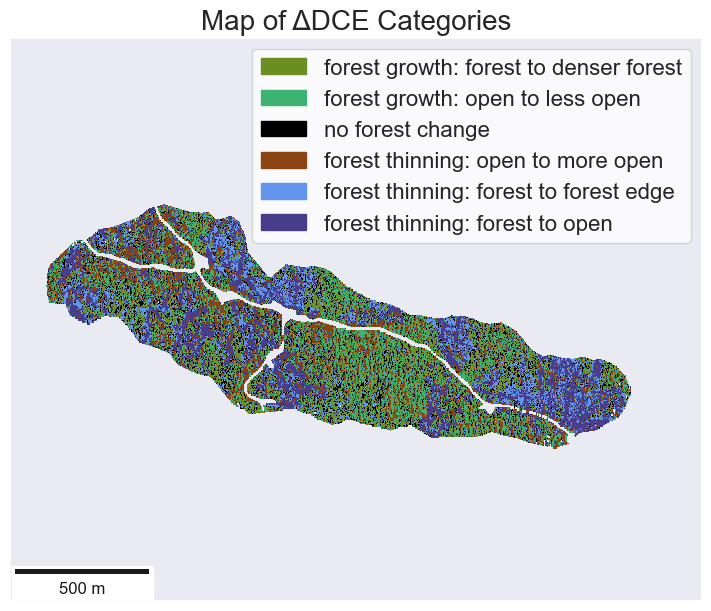

In [20]:
fig = plt.figure(figsize=(7,6), constrained_layout = True)
ax = fig.gca()

# color_zero = 'white'
color_zero = '#EAEAF2'

# plot 3
ds['delta_dce_cat'].plot(cmap=ListedColormap([color_zero, color_cat1,color_cat2,color_cat3,color_cat4,color_cat5,color_cat6]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {color_cat1: "forest growth: forest to denser forest", 
                  color_cat4: "forest growth: open to less open",
                  color_cat3: "no forest change",  
                  color_cat5: "forest thinning: open to more open",               
                  color_cat2: "forest thinning: forest to forest edge",
                  color_cat6: "forest thinning: forest to open",}

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

plt.legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white", fontsize=16, loc='upper right')

plt.title('')

ax.set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left') #rotation='horizontal-only'
ax.add_artist(scalebar)

plt.xlabel('');plt.ylabel('');plt.xticks([]);plt.yticks([])

# add a small C) in the left corner 
# plt.text(0.01, 0.95, 'C)', fontsize=18, color='dimgray', transform=ax.transAxes)20
plt.title('Map of ΔDCE Categories', fontsize=20)

# add very small text on the subplot C) which says "north" and "south" in small grey text 
# plt.text(0.53, 0.57, 'north side of the ridge', fontsize=fontsize_3, color='dimgray', transform=ax.transAxes) #(left/right, top/bottom, text)
# plt.text(0.15, 0.26, 'south side of the ridge', fontsize=fontsize_3, color='dimgray', transform=ax.transAxes)

# === Save and show ===
# figure_name = 'figure4_map_1.png'
# plt.savefig(figure_path + figure_name, dpi=500, bbox_inches='tight')

plt.show()

/home/cassie/programs/miniforge3/envs/cer_treatment/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


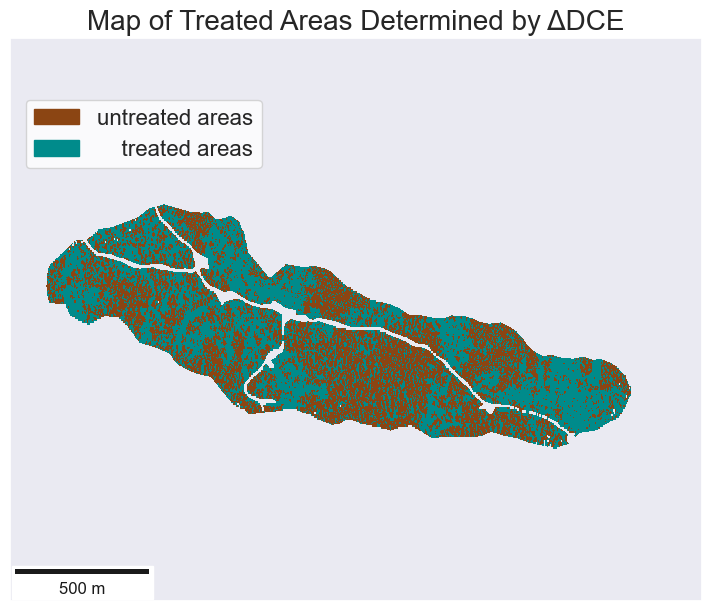

In [21]:
fig = plt.figure(figsize=(7,6), constrained_layout = True)
ax = fig.gca()

# color_zero = 'white'
color_zero = '#EAEAF2'

colorcontrol = 'saddlebrown'
colortreatment = 'darkcyan'

# plot 3
# ds['delta_dce_cat'].plot(cmap=ListedColormap([color_zero, color_cat1,color_cat2,color_cat3,color_cat4,color_cat5,color_cat6]), add_colorbar=False)  

# # Add a legend for labels, to have different labels for each plot
# legend_labels2 = {color_cat1: "forest growth: forest to denser forest", 
#                   color_cat4: "forest growth: open to less open",
#                   color_cat3: "no forest change",  
#                   color_cat5: "forest thinning: open to more open",               
#                   color_cat2: "forest thinning: forest to forest edge",
#                   color_cat6: "forest thinning: forest to open",}

ds['delta_dce_cat'].plot(cmap=ListedColormap([color_zero, colorcontrol, colortreatment, colorcontrol, colorcontrol, colortreatment, colortreatment]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {colorcontrol:   "untreated areas", 
                  colortreatment: "    treated areas"}

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

plt.legend(handles=patches2,
          bbox_to_anchor=(0.38, .91),
          facecolor="white", fontsize=16)

plt.title('')

ax.set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left') #rotation='horizontal-only'
ax.add_artist(scalebar)

plt.xlabel('');plt.ylabel('');plt.xticks([]);plt.yticks([])

# add a small C) in the left corner 
# plt.text(0.01, 0.95, 'C)', fontsize=18, color='dimgray', transform=ax.transAxes)

plt.title('Map of Treated Areas Determined by ΔDCE', fontsize=20)

# plt.text(0.53, 0.57, 'north side of the ridge', fontsize=fontsize_3, color='dimgray', transform=ax.transAxes) #(left/right, top/bottom, text)
# plt.text(0.15, 0.26, 'south side of the ridge', fontsize=fontsize_3, color='dimgray', transform=ax.transAxes)

# === Save and show ===
# figure_name = 'figure4_map_2.png'
# plt.savefig(figure_path + figure_name, dpi=500, bbox_inches='tight')

plt.show()

_________________________________________________________________________________________
## Maps, which include the missing values...

### Some Maps... but the maps created for the figure are in `figure7_delta_dce.ipynb` because they don't exclude zero values 

In [22]:
# Create a binary variable versions of all these areas
ds['control_treatment_binary'] = ds['sdv_diff_control_south_new_norm'].where(~(ds['sdv_diff_control_south_new_norm'] > 0), 1)
ds['control_treatment_binary'] = ds['control_treatment_binary'].where(~(ds['sdv_diff_control_north_new_norm'] > 0), 2)
ds['control_treatment_binary'] = ds['control_treatment_binary'].where(~(ds['sdv_diff_treatment_south_new_norm'] > 0), 3)
ds['control_treatment_binary'] = ds['control_treatment_binary'].where(~(ds['sdv_diff_treatment_north_new_norm'] > 0), 4)

ds['control_treatment_binary_cat'] = ds['sdv_diff_control_south_new_norm_cat'].where(~(ds['sdv_diff_control_south_new_norm_cat'] > 0), 1)
ds['control_treatment_binary_cat'] = ds['control_treatment_binary_cat'].where(~(ds['sdv_diff_control_north_new_norm_cat'] > 0), 2)
ds['control_treatment_binary_cat'] = ds['control_treatment_binary_cat'].where(~(ds['sdv_diff_treatment_south_new_norm_cat'] > 0), 3)
ds['control_treatment_binary_cat'] = ds['control_treatment_binary_cat'].where(~(ds['sdv_diff_treatment_north_new_norm_cat'] > 0), 4)

In [23]:
# colors by aspect for later figures
colorcontrolsouth = 'tan'
colorcontrolnorth = 'lightsteelblue'
colortreatmentsouth = 'darkorange'
colortreatmentnorth = 'darkblue'

/home/cassie/programs/miniforge3/envs/cer_treatment/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/cassie/programs/miniforge3/envs/cer_treatment/lib/python3.13/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


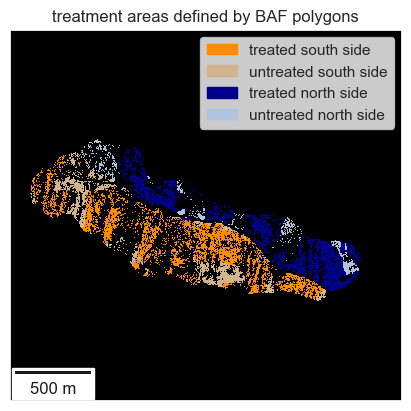

In [24]:
fig = plt.figure(figsize=(4,4), constrained_layout = True)
ax = fig.gca()

# plot 3
ds['control_treatment_binary'].plot(vmin=1, vmax=4, cmap=ListedColormap([colorcontrolsouth, colorcontrolnorth, colortreatmentsouth, colortreatmentnorth]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {colortreatmentsouth: "treated south side", 
                    colorcontrolsouth: "untreated south side",
                 colortreatmentnorth: "treated north side",                 
                 colorcontrolnorth: "untreated north side",} 
                 

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

plt.legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white")

ax.set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
ax.add_artist(scalebar)

plt.xlabel('');plt.ylabel('');plt.xticks([]);plt.yticks([])

plt.title('treatment areas defined by BAF polygons')

plt.show()

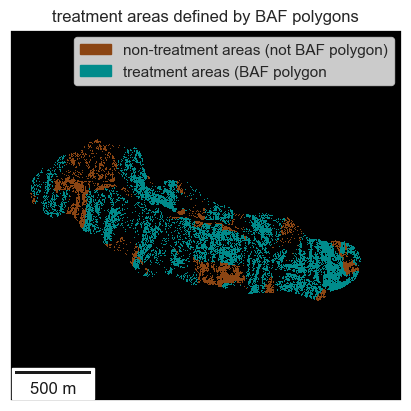

In [25]:
fig = plt.figure(figsize=(4,4), constrained_layout = True)
ax = fig.gca()

colorcontrol = 'saddlebrown'
colortreatment = 'darkcyan'

# plot 3
ds['control_treatment_binary'].plot(vmin=1, vmax=4, cmap=ListedColormap([colorcontrol, colorcontrol, colortreatment, colortreatment]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {colorcontrol: "non-treatment areas (not BAF polygon)", 
                  colortreatment: "treatment areas (BAF polygon"}
                 

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

plt.legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white")

ax.set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
ax.add_artist(scalebar)

plt.xlabel('');plt.ylabel('');plt.xticks([]);plt.yticks([])

plt.title('treatment areas defined by BAF polygons')

plt.show()

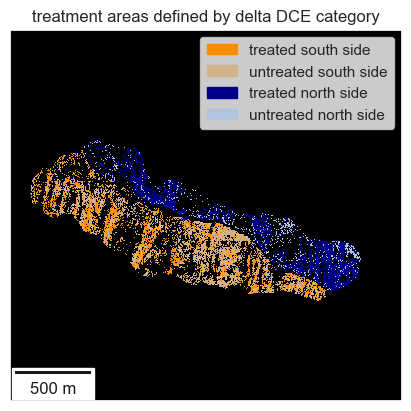

In [26]:
fig = plt.figure(figsize=(4,4), constrained_layout = True)
ax = fig.gca()

# plot 3
ds['control_treatment_binary_cat'].plot(vmin=1, vmax=4, cmap=ListedColormap([colorcontrolsouth, colorcontrolnorth, colortreatmentsouth, colortreatmentnorth]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {colortreatmentsouth: "treated south side", 
                    colorcontrolsouth: "untreated south side",
                 colortreatmentnorth: "treated north side",                 
                 colorcontrolnorth: "untreated north side",} 
                 

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

plt.legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white")

plt.title('')

ax.set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
ax.add_artist(scalebar)

plt.xlabel('');plt.ylabel('');plt.xticks([]);plt.yticks([])

plt.title('treatment areas defined by delta DCE category')

plt.show()

Now, color my treatment areas with the two colors, not four

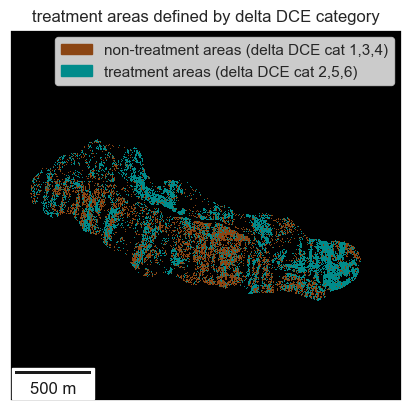

In [27]:
fig = plt.figure(figsize=(4,4), constrained_layout = True)
ax = fig.gca()

colorcontrol = 'saddlebrown'
colortreatment = 'darkcyan'

# plot 3
ds['control_treatment_binary_cat'].plot(vmin=1, vmax=4, cmap=ListedColormap([colorcontrol, colorcontrol, colortreatment, colortreatment]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {colorcontrol: "non-treatment areas (delta DCE cat 1,3,4)", 
                  colortreatment: "treatment areas (delta DCE cat 2,5,6)"}
                 

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

plt.legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white")

ax.set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
ax.add_artist(scalebar)

plt.xlabel('');plt.ylabel('');plt.xticks([]);plt.yticks([])

plt.title('treatment areas defined by delta DCE category')

plt.show()